In [71]:
import jax
import matplotlib.pyplot as plt
import pandas as pd
import optax
from flax.training.train_state import TrainState
from flax import linen as nn
from jax import numpy as jnp

In [72]:
# Reading in the Data
train_df = pd.read_csv("data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/sign_mnist_test.csv")

In [3]:
# Exploring the Data
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
# Extracting the Labels and Images
y_train = train_df.pop('label')
y_valid = valid_df.pop('label')

x_train = train_df.values
x_valid = valid_df.values

In [5]:
x_train.shape

(27455, 784)

In [6]:
y_train.shape

(27455,)

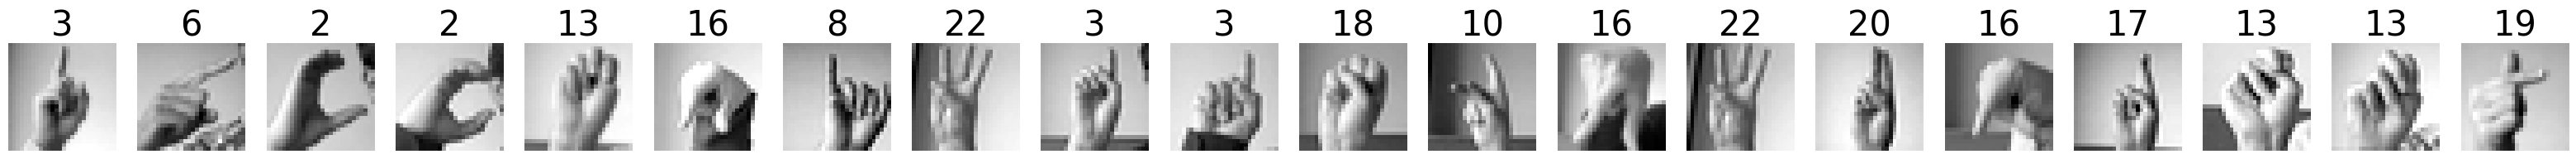

In [7]:
# Visualizing the Data
plt.figure(figsize=(40,40))

num_images = 20
for i in range(num_images):
    row = x_train[i]
    label = y_train[i]

    image = row.reshape(28,28)
    plt.subplot(1, num_images, i+1)
    plt.title(label, fontdict={'fontsize': 30})
    plt.axis('off')
    plt.imshow(image, cmap='gray')

In [8]:
x_train.min()

np.int64(0)

In [9]:
x_train.max()

np.int64(255)

In [10]:
# Normalizing the Data
x_train = x_train / 255
x_valid = x_valid / 255

In [11]:
class MyDataset:
    def __init__(self, x_df, y_df):
        self.xs = jnp.array(x_df)
        self.ys = jnp.array(y_df)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

In [12]:
BATCH_SIZE = 32

train_data = MyDataset(x_train, y_train)

In [13]:
# Batching the data
def create_batches(dataset, batch_size):
    num_batches = len(dataset) // batch_size
    for i in range(num_batches):
        yield dataset[i * batch_size:(i + 1) * batch_size]

# Creating batches
train_batches = list(create_batches(train_data, BATCH_SIZE))

# Putting the data on the device
train_loader = [jax.device_put(batch) for batch in train_batches]

In [14]:
valid_data = MyDataset(x_valid, y_valid)
valid_batches = list(create_batches(valid_data, BATCH_SIZE))
valid_loader = [jax.device_put(batch) for batch in valid_batches]

In [15]:
train_N = len(train_loader)
valid_N = len(valid_loader)

In [16]:
batch = next(iter(train_loader))
batch

(Array([[0.41960785, 0.4627451 , 0.49803922, ..., 0.8       , 0.79607844,
         0.7921569 ],
        [0.60784316, 0.6156863 , 0.6117647 , ..., 0.40392157, 0.5294118 ,
         0.58431375],
        [0.73333335, 0.7372549 , 0.7372549 , ..., 0.7647059 , 0.7607843 ,
         0.7647059 ],
        ...,
        [0.57254905, 0.58431375, 0.5882353 , ..., 0.7607843 , 0.74509805,
         0.73333335],
        [0.5254902 , 0.53333336, 0.54509807, ..., 0.6156863 , 0.58431375,
         0.5529412 ],
        [0.5803922 , 0.5921569 , 0.6156863 , ..., 0.44313726, 0.50980395,
         0.4862745 ]], dtype=float32),
 Array([ 3,  6,  2,  2, 13, 16,  8, 22,  3,  3, 18, 10, 16, 22, 20, 16, 17,
        13, 13, 19, 18, 21, 16, 23,  3, 23, 24, 18, 22,  1,  1, 12],      dtype=int32))

In [17]:
batch[0].shape

(32, 784)

In [18]:
# Build the Model
input_size = 28 * 28
n_classes = 26

In [35]:
class SimpleModel(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(features=n_classes)(x)
        x = nn.log_softmax(x)
        return x

In [36]:
# Initializing the Model
rng = jax.random.PRNGKey(0)
model = SimpleModel(features=512)


In [37]:
# initialize the parameters
params = model.init(jax.random.PRNGKey(0), batch[0])
# forward pass
y_pred = model.apply(params, batch[0])

In [38]:
y_pred[0]

Array([-3.3545861, -3.4645586, -3.8202145, -3.3521147, -2.8612044,
       -2.841241 , -3.4064667, -3.2638159, -3.30827  , -3.6876001,
       -3.4105215, -3.669836 , -3.5486255, -3.4766665, -3.1873283,
       -2.9187403, -3.6971486, -3.152741 , -3.5459042, -3.2010598,
       -2.7745152, -3.1388752, -2.814304 , -2.9584491, -3.597043 ,
       -3.4180439], dtype=float32)

In [39]:
# Optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

In [40]:
model_state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer,)

In [56]:
def calculate_loss(state, params, batch):
    data_input, labels = batch
    logits = state.apply_fn(params, data_input)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    loss = jnp.mean(loss)
    return loss

In [57]:
grad_fn = jax.value_and_grad(calculate_loss, argnums=1)

In [61]:
# Accuracy
def accuracy(y_true, y_pred):
    y_true = jnp.array(y_true)
    y_pred = jnp.argmax(y_pred, axis=1)
    return jnp.mean(y_true == y_pred)

In [58]:
@jax.jit
def train_step(state, batch):
    loss, grads = grad_fn(state, state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [66]:
def train_model(state, loader, epochs):
    loss = 0
    for epoch in range(epochs):
        for batch in loader:
            state, loss = train_step(state, batch)
        print(f"Epoch: {epoch}, Loss: {loss}")
        # accuracy
        acc = 0
        for batch in valid_loader:

            data_input, labels = batch
            logits = state.apply_fn(state.params, data_input)
            acc += accuracy(labels, logits)
        print(f"Accuracy: {acc / valid_N}")
    return state

In [68]:
model_state = train_model(model_state, train_loader, 100)

Epoch: 0, Loss: 1.0921701192855835
Accuracy: 0.5378069281578064
Epoch: 1, Loss: 0.5400298833847046
Accuracy: 0.6943359375
Epoch: 2, Loss: 0.3492923378944397
Accuracy: 0.7509765625
Epoch: 3, Loss: 0.17155691981315613
Accuracy: 0.7739955186843872
Epoch: 4, Loss: 0.04591194912791252
Accuracy: 0.8058035969734192
Epoch: 5, Loss: 0.21125072240829468
Accuracy: 0.7370256781578064
Epoch: 6, Loss: 0.003443292109295726
Accuracy: 0.814453125
Epoch: 7, Loss: 0.0466872863471508
Accuracy: 0.7721819281578064
Epoch: 8, Loss: 0.002055163960903883
Accuracy: 0.8307756781578064
Epoch: 9, Loss: 0.0007953073363751173
Accuracy: 0.8307756781578064
Epoch: 10, Loss: 0.024701770395040512
Accuracy: 0.7882254719734192
Epoch: 11, Loss: 0.002936303848400712
Accuracy: 0.8243582844734192
Epoch: 12, Loss: 0.0012725630076602101
Accuracy: 0.8247767686843872
Epoch: 13, Loss: 0.003641835181042552
Accuracy: 0.8258928656578064
Epoch: 14, Loss: 0.17931389808654785
Accuracy: 0.736328125
Epoch: 15, Loss: 0.0011275552678853273
Ac